# A Beginners Guide to Beating the Bookmakers with TensorFlow

This notebook tries to improve the original work.

This is done by 
- scaling the input data
- using keras (to know what we are doing)
- using tensorboard
- write custom callback to collect performance
- using a commitee of network
- cross validate the results

In [424]:
import dataset
book = dataset.Dataset('data/book.csv')

In [425]:
import pandas as pd
df = pd.DataFrame(book.processed_results)

Now the data is being split into a training and a test set.
Because the data is sorted by date, it's is not so bad use the the last rows as test set.

In [426]:
TRAINING_SET_FRACTION = 0.95
train_results_len = int(TRAINING_SET_FRACTION * df.shape[0])
train = df[:train_results_len]
test = df[train_results_len:]

Don't forget to drop the result from data set, otherwise we are learning the result

In [427]:
train_features = train.drop(columns=['result'])
train_labels = train.result.copy()
test_features = test.drop(columns=['result'])
test_labels = test.result.copy()

Scale the data. Remember to only use your train data to fit the scaler.

In [428]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
X_train = scaler.fit_transform(train_features.astype(float))
X_test = scaler.transform(test_features.astype(float))
encoder = LabelEncoder()
Y_train = -encoder.fit_transform(train_labels) +2
Y_test = -encoder.transform(test_labels) +2

Setup a keras environment

In [429]:
import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adagrad
from keras import regularizers
from keras import metrics

from keras import backend as K

from keras_tqdm import TQDMNotebookCallback

In [430]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(Y_train)
y_test = np_utils.to_categorical(Y_test)

In [431]:
import shutil
import os
if os.path.exists('logs'):
    shutil.rmtree('logs')

In [ ]:
K.clear_session()

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1],
                kernel_regularizer=regularizers.l1(0.001)
               ))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer=Adagrad(0.1),
              metrics = ['accuracy']
             )

model.fit(X_train, y_train,
      epochs=20000,
      batch_size=500, verbose=0,
      validation_data = [X_test, y_test],
      callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/run01', write_graph=True), 
                 TQDMNotebookCallback(show_inner=False)]
 )



Let's define the performance function.

Ideally, you would implement a metric, but since it's difficult to pass extra parameters to keras, 
for now, we only compute the performance at the end of the optimization.

In [607]:
def performance(th=0.05, features=test_features):
    def perf_metric(y_pred, y_true):
        odds = features[['odds-home','odds-draw','odds-away']]
        selection = (y_pred > (1./odds + th))
        profit = ( selection * (odds * y_true - 1)).sum()
        count = selection.sum()
        profit.columns=['profit-home','profit-draw','profit-away']
        profit.columns=['#bets-home','#bets-draw','#bets-away']
        return profit, count
    return perf_metric

In order to compute the performance, we need the predicted classes.

In [434]:
y_pred = model.predict(X_test)
result = pd.concat(performance(0.05)(y_pred, y_test),axis=1).rename(columns={0:'profit',1:'count'})
result['margin'] = result.profit / result['count']
display(result)

,profit,count,margin
odds-home,7.26,14,0.518571
odds-draw,1.38,12,0.115000
odds-away,7.71,17,0.453529


Now these margins are more in the range that were reported by Andrew. 

What's interesting is that we now have profits for all type of odds. This might be an indication that this model is more robust.

Since this is the first run, this could also be luck.
We need to find a way to repeat the results and also log the performance of the model.

Instead of rewriting all losses and metrics, we will implement a custom keras callback, which will log the
performance into a dataframe.

In [ ]:
model.save('models/revamped_00.h5')

In [ ]:
import csv
from IPython.display import clear_output
class MyLogger(keras.callbacks.Callback):
    def __init__(self):
        self.df = pd.DataFrame(columns=['iter','loss','acc','val_loss','val_acc','profit_home','best_home','margin_home','profit_draw','bets_draw','margin_draw','profit_away','bets_away','margin_away'])
        super(MyLogger, self).__init__()
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            y_pred = self.model.predict(X_test)
            result = pd.concat(performance(0.05)(y_pred, y_test),axis=1).rename(columns={0:'profit',1:'count'})
            result['margin'] = result.profit / result['count']
            values = [epoch] + list(logs.values()) + list(result.values.flat)
            self.df = self.df.append(pd.Series(values,index=self.df.columns),ignore_index=True)

In [ ]:
def train_model(X_train, y_train, X_test, y_test, iteration=1):
    log_dir = 'logs/run_%02d' % iteration
    if os.path.exists(log_dir):
        shutil.rmtree(log_dir)
        
    K.clear_session()

    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1],
                    kernel_regularizer=regularizers.l1(0.001)
                   ))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adagrad(0.1),
                  metrics = ['accuracy']
                 )

    logger = MyLogger()
    model.fit(X_train, y_train,
          epochs=20000,
          batch_size=500, verbose=0,
          validation_data = [X_test, y_test],
          callbacks=[keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=True),
                     logger,
                     TQDMNotebookCallback(show_inner=False)]
     )
    return model, logger.df

In [ ]:
for iteration in range(1, 11):
    model, df = train_model(X_train, y_train, X_test, y_test, iteration)
    model.save('models/revamped_%02d.h5' % iteration)
    df.to_csv('csv/training_log_%02d.csv' % iteration)

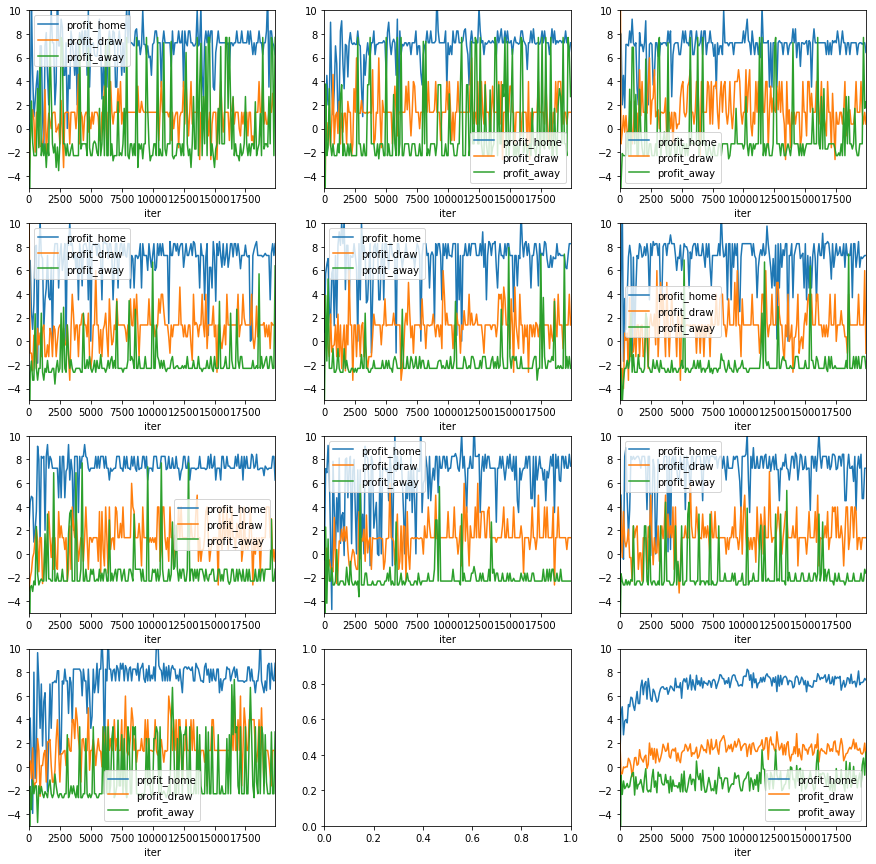

In [435]:
from matplotlib import pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(15,15))
axs = fig.subplots(4,3)

from collections.abc import Iterable
def flatten(arr):
    for i in arr:
        if isinstance(i, Iterable):
            yield from flatten(i)
        else:
            yield i
    
axs = list(flatten(axs))
dataframes = []
for i in range(1, 11):
    df = pd.read_csv('csv/training_log_%02d.csv' % i).set_index('iter').drop(columns=['Unnamed: 0'])
    if not df.empty:
        _ = df[['profit_home','profit_draw','profit_away']].plot(ylim=(-5,10),ax=axs[i-1])
        dataframes.append(df)
        
# Last plot is the average of all graphs
df = pd.concat({n: df for n, df in enumerate(dataframes)},axis=0)
_ = df[['profit_home','profit_draw','profit_away']].mean(level=1).plot(ax=axs[11],ylim=(-5,10))

When looking at these graphs, I wouldn't go for Andrew's draw betting strategu, but go for the 
home betting strategy. This will give you an average of 7% (if bookies will allow you to play in the long term).

# A commitee of neural networks

Let's examine if we can combine these networks. We will use the mean probability of the network ensemble for our strategy.

In [501]:
from keras.models import load_model
predictions = []
for i in range(1, 11):
    _model = load_model('models/revamped_%02d.h5' % i)
    pred = _model.predict(X_test)
    predictions.append(pred)
ypred = pd.concat({n: pd.DataFrame(df, columns=['prob-home','prob-draw','prob-away']) for n, df in enumerate(predictions)},axis=0)

We compute the profit for the mean probability computed by the commitee, profit for the most optimistic commitee and the most pessimistic commitee.

In [543]:
mean_pred = ypred.mean(level=1).values
min_pred = ypred.min(level=1).values
max_pred = ypred.max(level=1).values
mean_p = pd.concat(performance(0.05)(mean_pred, y_test), axis=1).rename_axis('mean')
min_p = pd.concat(performance(0.05)(min_pred, y_test), axis=1).rename_axis('min')
max_p = pd.concat(performance(0.05)(max_pred, y_test), axis=1).rename_axis('max')
for df in [mean_p, min_p, max_p]:
    df.columns = ['profit ' + df.axes[0].name,'bets ' + df.axes[0].name]
pd.concat([mean_p, max_p, min_p], axis=1)

,profit mean,bets mean,profit max,bets max,profit min,bets min
odds-home,7.26,14,9.26,17,8.00,11
odds-draw,1.38,12,-1.02,18,-1.01,11
odds-away,-1.29,15,5.71,19,-2.06,13


We obtain most profit if we believe the most optimistic commitee. 
But this is essentially equivalent as shifting the threshold.

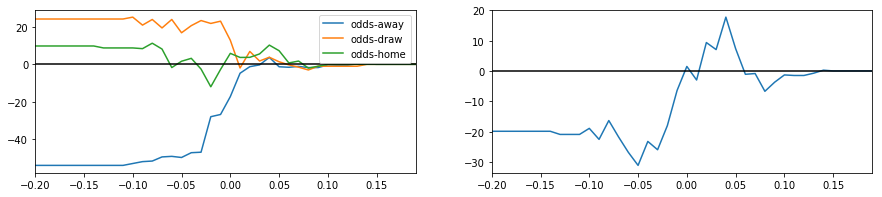

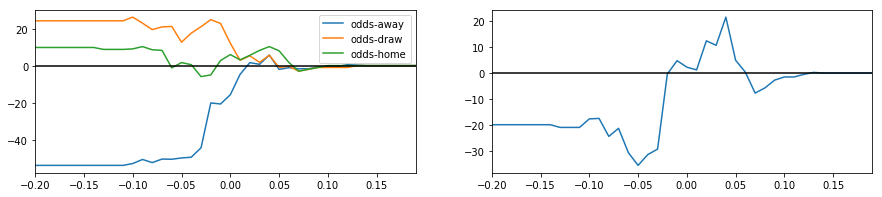

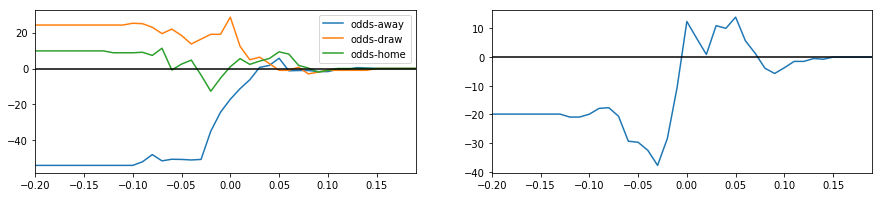

In [546]:
import numpy as np
for preds in [mean_pred, min_pred, max_pred]:
    profits = pd.DataFrame()
    bets = pd.DataFrame()
    for th in np.arange(-0.2, 0.2, 0.01):
        pr, b = performance(th)(preds, y_test)
        pr.name = th
        b.name = th
        profits = profits.append(pr)
        bets = bets.append(b)
    fig = plt.figure(figsize=(15,3))
    axs = fig.subplots(1,2)
    f = profits.plot(ax=axs[0])
    f.plot((-0.2,0.2),(0,0),'k')
    f = profits.sum(axis=1).plot(ax=axs[1])
    f.plot((-0.2,0.2),(0,0),'k')

There seems to be a consensus that the commitees add generate some value for probability difference higher than 0.
The choice of predicting the draw by Andrew, I believe is motivated by the fact that for this particular dataset, 
betting the draw generates the most profit.

We need to check if our model generalizes across seasons.

While it is bad practice to use results from the future to check if you can generate profit in bets or stocks,
for now, we will simpy use cross validation to check the potential of using this model to actually place bets.

# Cross validation

In [624]:
def create_fn():
    K.clear_session()

    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1],
                    kernel_regularizer=regularizers.l1(0.001)
                   ))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adagrad(0.1),
                  metrics = ['accuracy']
                 )

    return model

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
estimator = KerasRegressor(build_fn=create_fn, epochs=20000, batch_size=500, verbose=0)

In [625]:
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
seed = 42
kfold = KFold(n_splits=20, random_state=seed, 
              # shuffle=True
             )


In [ ]:
y_pred = cross_val_predict(estimator, X_train, y_train, cv=kfold)

Now this took a long time :-(
Let's save the results for future reference

In [652]:
pd.DataFrame(y_pred).to_hdf('cross_predictions.h5', 'y_pred')

In [654]:
df = pd.concat(performance(0.05, train_features)(y_pred, y_train),axis=1)
df.columns = ['Profit','#Bets']
display(df)

,Profit,#Bets
odds-home,-2.23,331
odds-draw,-4.52,275
odds-away,-1.80,140


# Conclusion

With this simple model, using multi-class classification, it seems rather impossible to earn money with sports betting. The results reported seem to be related to the specific split for the training and test set.

Although, there are still a number of parameters to be tuned (eg. performance threshold, number of hidden layers and size of the layer), I hope this article shows that relying on a single test, without cross validation, is not a good strategy to start betting your money on soccer matches. But maybe that's what bookmakers want you to believe.